# Implementing a Physics-Informed Neural Network (PINN) that solves the Non-Linear Schrödinger (NLS) Equation.

-Krishnanjan Sil

GitHub Profile: https://github.com/Krishnanjan-Sil

JAX Device: cuda:0
Generating training data...
Starting training for 1000 epochs...
Epoch 00000 | Loss: 4.055676e-01
Epoch 01000 | Loss: 2.077326e-05
Training finished in 392.31 seconds.


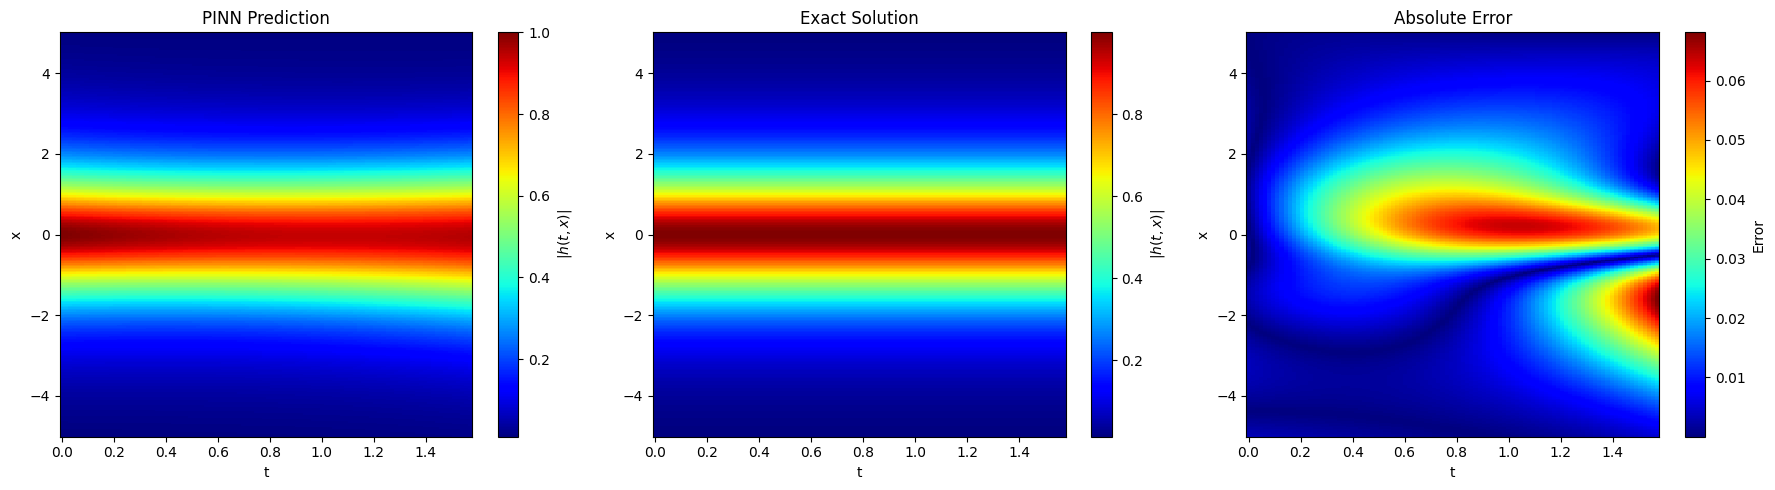

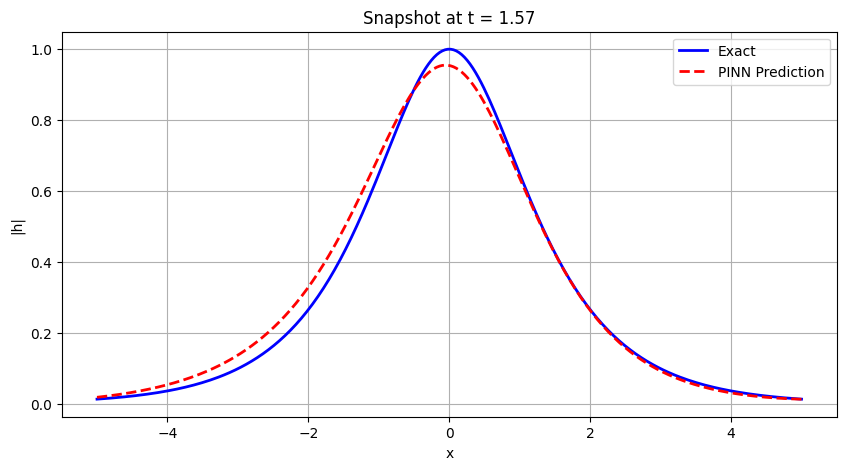

In [ ]:
# ==========================================
# 1. SETUP AND INSTALLATION
# ==========================================
# Install optax for optimization (JAX's standard optimizer library)
!pip install optax matplotlib -q

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import optax
import matplotlib.pyplot as plt
import numpy as np
import time

# Enable float64 for higher precision (crucial for scientific computing)
jax.config.update("jax_enable_x64", True)

print(f"JAX Device: {jax.devices()[0]}")

# ==========================================
# 2. PROBLEM DEFINITION & EXACT SOLUTION
# ==========================================
# Equation: i*h_t + 0.5*h_xx + |h|^2*h = 0
# Domain: x in [-5, 5], t in [0, pi/2]
# Exact Solution (Bright Soliton): h(t,x) = sech(x) * exp(i * 0.5 * t)

def exact_solution(t, x):
    """
    Computes the analytical solution for validation.
    Returns complex h, real part u, imaginary part v.
    """
    # |h| = sech(x)
    # Phase = exp(i * 0.5 * t)
    envelope = (2 / (jnp.exp(x) + jnp.exp(-x))) # sech(x) manually for stability
    phase = jnp.exp(1j * 0.5 * t)
    h = envelope * phase
    return h, jnp.real(h), jnp.imag(h)

# ==========================================
# 3. NEURAL NETWORK ARCHITECTURE
# ==========================================
# We use a Multi-Layer Perceptron (MLP).
# Input: [t, x] (2 features)
# Output: [u, v] (2 features: Real and Imaginary parts of h)

def init_params(layers, key):
    """Initialize MLP weights and biases."""
    params = []
    keys = random.split(key, len(layers))

    for i in range(len(layers) - 1):
        in_dim, out_dim = layers[i], layers[i+1]
        # Xavier/Glorot Initialization
        limit = jnp.sqrt(6.0 / (in_dim + out_dim))
        W = random.uniform(keys[i], (in_dim, out_dim), minval=-limit, maxval=limit)
        b = jnp.zeros((out_dim,))
        params.append((W, b))
    return params

def forward(params, t, x):
    """
    Forward pass of the neural network.
    Inputs: t (scalar), x (scalar)
    Returns: u (scalar), v (scalar)
    """
    # Concatenate t and x to form input vector
    inputs = jnp.stack([t, x])

    # Pass through hidden layers
    for W, b in params[:-1]:
        inputs = jnp.dot(inputs, W) + b
        inputs = jnp.tanh(inputs) # Tanh is standard for PINNs

    # Output layer (Linear activation)
    W_out, b_out = params[-1]
    outputs = jnp.dot(inputs, W_out) + b_out

    # Split output into real (u) and imaginary (v) parts
    u = outputs[0]
    v = outputs[1]
    return u, v

# ==========================================
# 4. PHYSICS INFORMED LOSS FUNCTIONS
# ==========================================

# We need derivatives of u and v w.r.t t and x.
# We use jax.grad to get automatic derivatives.

# Jacobian-Vector products or explicit grad calls?
# Since input is scalar-to-scalar per point, we define gradients for single samples
# and then vmap (vectorize) them over the batch.

def get_derivatives(params, t, x):
    """Compute u, v and their partial derivatives."""

    # Function to get u and v from params, t, x
    fn = lambda t, x: forward(params, t, x)

    # First derivatives
    # grad(fn, argnums=0)(t, x) gets derivative w.r.t t
    u_t_fn = grad(lambda t, x: fn(t, x)[0], 0)
    v_t_fn = grad(lambda t, x: fn(t, x)[1], 0)
    u_x_fn = grad(lambda t, x: fn(t, x)[0], 1)
    v_x_fn = grad(lambda t, x: fn(t, x)[1], 1)

    # Second derivatives
    u_xx_fn = grad(lambda t, x: u_x_fn(t, x), 1)
    v_xx_fn = grad(lambda t, x: v_x_fn(t, x), 1)

    u = fn(t, x)[0]
    v = fn(t, x)[1]
    u_t = u_t_fn(t, x)
    v_t = v_t_fn(t, x)
    u_xx = u_xx_fn(t, x)
    v_xx = v_xx_fn(t, x)

    return u, v, u_t, v_t, u_xx, v_xx

def pde_residual(params, t, x):
    """
    Computes the residual of the NLS equation.
    Goal: minimize this to 0.

    NLS: i*h_t + 0.5*h_xx + |h|^2*h = 0
    Let h = u + iv

    Real part (f_u): -v_t + 0.5*u_xx + (u^2 + v^2)*u = 0
    Imag part (f_v):  u_t + 0.5*v_xx + (u^2 + v^2)*v = 0
    """
    u, v, u_t, v_t, u_xx, v_xx = get_derivatives(params, t, x)

    h2 = u**2 + v**2

    f_u = -v_t + 0.5 * u_xx + h2 * u
    f_v =  u_t + 0.5 * v_xx + h2 * v

    return f_u, f_v

# Vectorize the residual calculation for a batch of data
batch_pde_residual = vmap(pde_residual, in_axes=(None, 0, 0))
batch_forward = vmap(forward, in_axes=(None, 0, 0))

def loss_fn(params, batch_collocation, batch_ic, batch_bc):
    """
    Total Loss = Loss_PDE + Loss_IC + Loss_BC
    """
    # 1. Physics Loss (Collocation points inside domain)
    t_c, x_c = batch_collocation[:, 0], batch_collocation[:, 1]
    f_u, f_v = batch_pde_residual(params, t_c, x_c)
    loss_pde = jnp.mean(f_u**2 + f_v**2)

    # 2. Initial Condition Loss (t=0)
    t_ic, x_ic = batch_ic[:, 0], batch_ic[:, 1]
    u_pred, v_pred = batch_forward(params, t_ic, x_ic)

    # Calculate exact u, v at t=0
    _, u_exact, v_exact = exact_solution(t_ic, x_ic)
    loss_ic = jnp.mean((u_pred - u_exact)**2 + (v_pred - v_exact)**2)

    # 3. Boundary Condition Loss (Periodic boundaries at x=-5 and x=5)
    # In this simplified demo, we enforce exact Dirichlet BCs from analytical solution
    # to speed up convergence, or we can enforce periodicity.
    # Let's enforce Hard Dirichlet BCs (matching exact solution at boundaries).
    t_bc, x_bc = batch_bc[:, 0], batch_bc[:, 1]
    u_bc_pred, v_bc_pred = batch_forward(params, t_bc, x_bc)
    _, u_bc_exact, v_bc_exact = exact_solution(t_bc, x_bc)
    loss_bc = jnp.mean((u_bc_pred - u_bc_exact)**2 + (v_bc_pred - v_bc_exact)**2)

    return loss_pde + loss_ic + loss_bc

@jit
def update(params, opt_state, col, ic, bc):
    """Performs one step of gradient descent."""
    loss, grads = jax.value_and_grad(loss_fn)(params, col, ic, bc)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

# ==========================================
# 5. DATA GENERATION
# ==========================================
print("Generating training data...")
key = random.PRNGKey(42)

# Domain bounds
x_min, x_max = -5.0, 5.0
t_min, t_max = 0.0, jnp.pi/2

# A. Collocation Points (Random sampling inside domain for Physics Loss)
N_f = 20000 # Number of collocation points
key, subkey = random.split(key)
t_col = random.uniform(subkey, (N_f, 1), minval=t_min, maxval=t_max)
x_col = random.uniform(subkey, (N_f, 1), minval=x_min, maxval=x_max)
collocation_data = jnp.concatenate([t_col, x_col], axis=1)

# B. Initial Condition Points (t=0)
N_0 = 100 # Number of IC points
x_0 = jnp.linspace(x_min, x_max, N_0)[:, None]
t_0 = jnp.zeros_like(x_0)
ic_data = jnp.concatenate([t_0, x_0], axis=1)

# C. Boundary Condition Points (x=-5 and x=5)
N_b = 100
t_b = random.uniform(key, (N_b, 1), minval=t_min, maxval=t_max)
x_b_left = jnp.ones_like(t_b) * x_min
x_b_right = jnp.ones_like(t_b) * x_max
# Combine left and right boundaries
bc_data = jnp.concatenate([
    jnp.concatenate([t_b, x_b_left], axis=1),
    jnp.concatenate([t_b, x_b_right], axis=1)
], axis=0)

# ==========================================
# 6. TRAINING LOOP
# ==========================================
# Hyperparameters
layers = [2, 100, 100, 100, 100, 2] # [Input, Hidden..., Output]
learning_rate = 1e-3
epochs = 1000

# Initialize
params = init_params(layers, key)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

print(f"Starting training for {epochs} epochs...")
start_time = time.time()

loss_history = []

for epoch in range(epochs + 1):
    params, opt_state, loss_val = update(params, opt_state, collocation_data, ic_data, bc_data)

    if epoch % 1000 == 0:
        loss_history.append(loss_val)
        print(f"Epoch {epoch:05d} | Loss: {loss_val:.6e}")

elapsed = time.time() - start_time
print(f"Training finished in {elapsed:.2f} seconds.")

# ==========================================
# 7. EVALUATION & VISUALIZATION
# ==========================================

# Create a meshgrid to visualize the entire domain
t_star = jnp.linspace(t_min, t_max, 100)
x_star = jnp.linspace(x_min, x_max, 256)
T, X = jnp.meshgrid(t_star, x_star)

# Flatten for prediction
t_flat = T.flatten()
x_flat = X.flatten()

# Predict using trained PINN
u_pred, v_pred = batch_forward(params, t_flat, x_flat)
h_pred = u_pred + 1j * v_pred
h_mag_pred = jnp.abs(h_pred).reshape(X.shape)

# Calculate Exact Solution
_, _, _ = exact_solution(t_flat, x_flat) # Just to check
h_exact, _, _ = exact_solution(T, X)
h_mag_exact = jnp.abs(h_exact)

# PLOTTING
plt.figure(figsize=(18, 5))

# Plot 1: Predicted magnitude |h(t,x)|
plt.subplot(1, 3, 1)
plt.pcolormesh(T, X, h_mag_pred, cmap='jet', shading='auto')
plt.colorbar(label='$|h(t,x)|$')
plt.xlabel('t')
plt.ylabel('x')
plt.title('PINN Prediction')

# Plot 2: Exact magnitude
plt.subplot(1, 3, 2)
plt.pcolormesh(T, X, h_mag_exact, cmap='jet', shading='auto')
plt.colorbar(label='$|h(t,x)|$')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Exact Solution')

# Plot 3: Error
plt.subplot(1, 3, 3)
err = jnp.abs(h_mag_pred - h_mag_exact)
plt.pcolormesh(T, X, err, cmap='jet', shading='auto')
plt.colorbar(label='Error')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Absolute Error')

plt.tight_layout()
plt.show()

# Plot 4: Slice at final time step
plt.figure(figsize=(10, 5))
t_slice = t_max
x_slice = x_star
# Prepare input for slice
t_vec = jnp.ones_like(x_slice) * t_slice
u_slice_pred, v_slice_pred = batch_forward(params, t_vec, x_slice)
h_slice_pred = jnp.abs(u_slice_pred + 1j * v_slice_pred)

# Exact at slice
h_slice_exact, _, _ = exact_solution(t_vec, x_slice)
h_slice_exact = jnp.abs(h_slice_exact)



plt.plot(x_slice, h_slice_exact, 'b-', label='Exact', linewidth=2)
plt.plot(x_slice, h_slice_pred, 'r--', label='PINN Prediction', linewidth=2)
plt.title(f'Snapshot at t = {t_slice:.2f}')
plt.xlabel('x')
plt.ylabel('|h|')
plt.legend()
plt.grid(True)
plt.show()